# Quickstart

The package provides functions for simulating temperature variations using the Infinite Cylinder Source (ICS) model or Infinite Line source (ILS), running full E-TRT simulations, and performing Bayesian inversion to estimate thermal parameters. Below are examples of how to use these functionalities.

# Compute Temperature with ICS Model

Below is an example of how to compute temperature variations at different distances and times using the Infinite Cylinder Source (ICS) model.

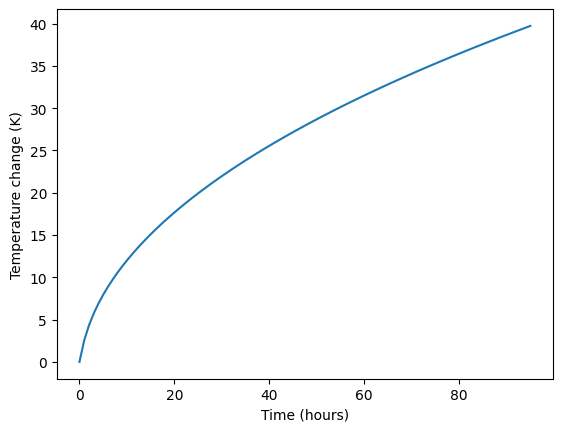

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from etrt import ICS
# Compute temperature at different distances and times
T_variation = ICS(
    r=np.array([0.083]),             # distances from borehole (m)
    t=np.arange(96),                 # times (hours)
    q=5000,                          # heat injection rate (W/m)
    k=2.5,                           # thermal conductivity (W/m·K)
    c=2.3,                           # volumetric heat capacity (MJ/m³·K)
    rbh=0.083                        # borehole radius (m)
)

# Plot temperature variation over time
plt.plot(np.arange(96), T_variation)
plt.xlabel("Time (hours)")
plt.ylabel('Temperature change (K)')
plt.show()

# Perform the E-TRT Simulation

We can run a full E-TRT simulation that combines both thermal and electrical responses. The example below demonstrates how to set up and execute the simulation, and then plot the results.

/Users/gabfab/py312/lib/python3.12/site-packages/simpeg/base/pde_simulation.py:639: PerformanceWarning: The 'pymatsolver.SolverLU' solver might lead to high computation times. We recommend using a faster alternative such as 'pymatsolver.Pardiso' or 'pymatsolver.Mumps'.
  super().__setattr__(name, value)
/Users/gabfab/py312/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
/Users/gabfab/py312/lib/python3.12/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


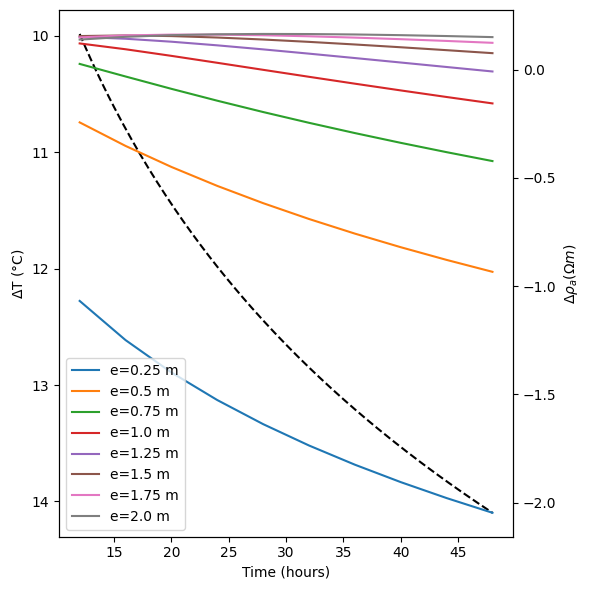

In [2]:
from etrt import simulate_etrt, ert_setup
import numpy as np
import matplotlib.pyplot as plt
# Bedrock thermal parameters
C = 2.5     # volumetric heat capacity (MJ/m^3/K)
k = 2.75    # thermal conductivity (W/m/K)
m = 0.035   # coupling parameter (/degC)

# SCW parameters
rBH = 0.165/2  # Radius of borehole (m)

# Thermal parameters
T0 = 10   # Initial water temperature (degC)
q = 115.6 # Heat injection rate (W/m)

# Electrical parameters
sigma_ref = 1/15  # Rock electrical conductivity at reference (S/m)
sigmaw_ref = 0.5  # Water electrical conductivity at reference (S/m)

# Setup ERT
zrec = np.arange(0.25, 2.25, 0.25)  # Electrode separation
mesh, simulation, survey= ert_setup(zrec, mesh_selection="fast")

# Sampling times
t_TRT = np.arange(12, 48+1/6, 1/4)  # TRT sampling (h)
t_ERT = np.arange(12, 48+2, 4)      # Electrical resistivity sampling (h)

# Run simulation
d = simulate_etrt(k, C, q, m, sigma_ref, rBH, t_ERT, t_TRT,
                  mesh, survey, simulation)
rhoa = d[:len(t_ERT)*len(zrec)].reshape(-1, len(zrec))
dT = d[len(t_ERT)*len(zrec):]

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(t_TRT, dT, "k--", label="Temperature")
ax.invert_yaxis()
ax.set_ylabel('$\\Delta $T (°C)')
ax1 = ax.twinx()
for i in range(len(zrec)):
    ax1.plot(t_ERT, rhoa[:, i], '-', label=f"e={zrec[i]} m")
ax1.legend()
ax1.set_ylabel('$\\Delta \\rho_a (\\Omega m)$')
ax.set_xlabel("Time (hours)")
plt.tight_layout()
plt.show()

## Bayesian Inversion

For parameter estimation, we can perform a Bayesian inversion that combines both temperature and resistivity data. Below is an example of how to set up and execute the inversion, and then print the estimated parameters with their uncertainties.

First, we look at the TRT test, without electrical data.

In [3]:
from etrt import bayesian_inversion

# Setup true and initial parameters
m0 = np.r_[2.6, 2, 0.018]
mtrue = np.r_[k, C, m]

# Covariance matrices
Cdi_trt = np.diag([1/0.26**2] * len(t_TRT))  # TRT data covariance
Cdi_ert = np.diag([1/0.09**2] * len(t_ERT) * len(zrec))  # ERT data covariance
Cdi = np.block([
    [Cdi_ert, np.zeros((len(t_ERT)*len(zrec), len(t_TRT)))],
    [np.zeros((len(t_TRT), len(t_ERT)*len(zrec))), Cdi_trt]
])  # Combined covariance

# Standard TRT inversion
def fun(m):
    dt, J = ICS(rBH, t_TRT * 3600, q, m[0], m[1], rBH, getJ=True)
    return dt, J[:, :2]

d, Jtrt = fun(mtrue)
m_est, *_ = bayesian_inversion(d, m0[:-1], None, Cdi_trt, fun, 10,
                               step=0.8, doprint=True, prior=False)

dinv, Jtrt = fun(m_est)
Cm_trt = np.linalg.inv(Jtrt.T@Cdi_trt@Jtrt)

print('                             k         Cs')
print('True parameters           ', mtrue[:-1])
print('TRT estimated parameters', m_est)
print('TRT confidence interval', 1.96 * np.sqrt(np.diag(Cm_trt)))
print('TRT confidence interval', 1.96 * np.sqrt(np.diag(Cm_trt))/mtrue[:-1] * 100, '%')

iter 0: cost = 3.381724e+03 (data = 3.381724e+03)model_params = [2.71510947 2.33436486]
iter 1: cost = 2.347461e+02 (data = 2.347461e+02)model_params = [2.7428805  2.46011937]
iter 2: cost = 1.146670e+01 (data = 1.146670e+01)model_params = [2.74857432 2.49164283]
iter 3: cost = 4.823042e-01 (data = 4.823042e-01)model_params = [2.74971485 2.49831195]
iter 4: cost = 1.949886e-02 (data = 1.949886e-02)model_params = [2.74994297 2.49966171]
iter 5: cost = 7.816395e-04 (data = 7.816395e-04)model_params = [2.74998859 2.49993232]
iter 6: cost = 3.127911e-05 (data = 3.127911e-05)model_params = [2.74999772 2.49998646]
iter 7: cost = 1.251272e-06 (data = 1.251272e-06)model_params = [2.74999954 2.49999729]
iter 8: cost = 5.005176e-08 (data = 5.005176e-08)model_params = [2.74999991 2.49999946]
iter 9: cost = 2.002077e-09 (data = 2.002077e-09)model_params = [2.74999998 2.49999989]
                             k         Cs
True parameters            [2.75 2.5 ]
TRT estimated parameters [2.74999998 2.

Next, we perform the inversion using both TRT and ERT data.

In [4]:
# Joint inversion of temperature and resistivity data
def fun(m):
    return simulate_etrt(m[0], m[1], q, m[2], sigma_ref, rBH, t_ERT, t_TRT,
                         mesh, survey, simulation, getJ=True,
                         sigma_water=sigmaw_ref)

d, J = fun(mtrue)
m_est, *_ = bayesian_inversion(d, m0, None, Cdi, fun, 5,
                           step=0.8, doprint=True, prior=False)
dinv, Jetrt = fun(m_est)
Cm_etrt = np.linalg.inv(Jetrt.T@Cdi@Jetrt)

print('                               k         Cs         m')
print('True parameters           ', mtrue)
print('E-TRT estimated parameters', m_est)
print('E-TRT confidence interval ', 1.96 * np.sqrt(np.diag(Cm_etrt)))
print('E-TRT confidence interval ', 1.96 * np.sqrt(np.diag(Cm_etrt))/mtrue * 100, '%')

iter 0: cost = 4.911758e+03 (data = 4.911758e+03)model_params = [2.74187332 2.26664101 0.02897454]
iter 1: cost = 3.559502e+02 (data = 3.559502e+02)model_params = [2.7644475  2.40016444 0.03335985]
iter 2: cost = 1.748762e+01 (data = 1.748762e+01)model_params = [2.75789003 2.46462972 0.03459973]
iter 3: cost = 7.511079e-01 (data = 7.511079e-01)model_params = [2.75282827 2.48918386 0.03490588]
iter 4: cost = 3.193418e-02 (data = 3.193418e-02)model_params = [2.75085728 2.49698181 0.03497815]
                               k         Cs         m
True parameters            [2.75  2.5   0.035]
E-TRT estimated parameters [2.75085728 2.49698181 0.03497815]
E-TRT confidence interval  [0.09024949 0.25868396 0.00170298]
E-TRT confidence interval  [ 3.28179975 10.34735841  4.86566737] %
